In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from common.network import DuelingNetwork
from common.hparameter import *

cpu


In [2]:
"speed"
speed = "slow" # "slow", "equal" or "fast"

"reward"
reward_p = "indiv" # "indiv" or "share"

In [3]:
""" seed """
seed =0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

''' divice '''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

""" Network """
net_p1 = DuelingNetwork(26, 13).to(device)
net_p2 = DuelingNetwork(26, 13).to(device)
net_p3 = DuelingNetwork(26, 13).to(device)
net_e = DuelingNetwork(26, 13).to(device)

""" Environment """
env_dir = os.path.join(os.pardir, 'c3ae')
sys.path.append(env_dir)
from chase3_and_escape import Chase3AndEscape

if speed == "fast":
    speed_p = 3.6
elif speed == "equal":
    speed_p = 3.0
elif speed == "slow":
    speed_p = 2.4

speed_e = 3
max_step_episode = 300
env = Chase3AndEscape(speed_pursuer1=speed_p, speed_pursuer2=speed_p, speed_pursuer3=speed_p, speed_evader=speed_e, max_step=max_step_episode, reward_share=True)

""" Load """
net_p1.load_state_dict(torch.load("../model/c3ae/reward_" + reward_p + "/p1_" +  str (speed_p) + ".pth")) 
net_p2.load_state_dict(torch.load("../model/c3ae/reward_" + reward_p + "/p2_" +  str (speed_p) + ".pth")) 
net_p3.load_state_dict(torch.load("../model/c3ae/reward_" + reward_p + "/p3_" +  str (speed_p) + ".pth")) 
net_e.load_state_dict(torch.load("../model/c3ae/reward_" + reward_p + "/e_" +  str (speed_p) + ".pth")) 

""" No. of episodes """
num_episodes_test = 10

In [4]:
pursuer1_pos_list = []
pursuer2_pos_list = []
pursuer3_pos_list = []
evader_pos_list = []

for episode in range(num_episodes_test):
    
    '''reset'''    
    pursuer1_pos_episode = []
    pursuer2_pos_episode = []
    pursuer3_pos_episode = []
    evader_pos_episode = []
    obs_p1, obs_p2, obs_p3, obs_e = env.reset()
    obs_p1, obs_p2, obs_p3, obs_e = torch.Tensor(obs_p1), torch.Tensor(obs_p2), torch.Tensor(obs_p3), torch.Tensor(obs_e)
    done = False
    step_episode = 0
        
    while not done:        

        action_p1 = net_p1.act(obs_p1.float().to(device), 0)
        action_p2 = net_p2.act(obs_p2.float().to(device), 0)
        action_p3 = net_p3.act(obs_p3.float().to(device), 0)
        action_e = net_e.act(obs_e.float().to(device), 0)
        
        next_obs_p1, next_obs_p2, next_obs_p3, next_obs_e, reward_p1, reward_p2, reward_p3, reward_e, done = env.step(action_p1, action_p2, action_p3, action_e, step_episode)
        next_obs_p1, next_obs_p2, next_obs_p3, next_obs_e = torch.Tensor(next_obs_p1), torch.Tensor(next_obs_p2), torch.Tensor(next_obs_p3), torch.Tensor(next_obs_e)
                
        obs_p1 = next_obs_p1
        obs_p2 = next_obs_p2
        obs_p3 = next_obs_p3
        obs_e = next_obs_e
        
        step_episode += 1        
        pos_pursuer1 = env.pos_p1
        pos_pursuer2 = env.pos_p2
        pos_pursuer3 = env.pos_p3
        pos_evader = env.pos_e
        pursuer1_pos_episode.append(pos_pursuer1)
        pursuer2_pos_episode.append(pos_pursuer2)
        pursuer3_pos_episode.append(pos_pursuer3)
        evader_pos_episode.append(pos_evader)
    
    pursuer1_pos_list.append(pursuer1_pos_episode)
    pursuer2_pos_list.append(pursuer2_pos_episode)
    pursuer3_pos_list.append(pursuer3_pos_episode)
    evader_pos_list.append(evader_pos_episode)

<IPython.core.display.Javascript object>


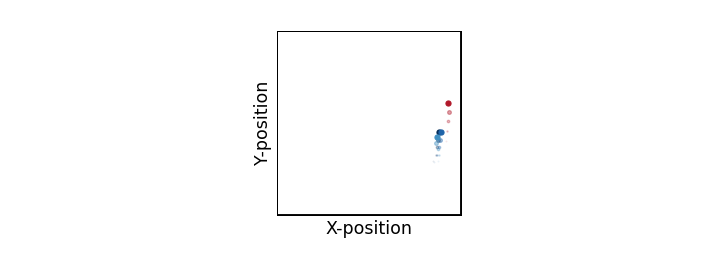

In [5]:
%matplotlib notebook
from matplotlib import animation

red = [177/255, 24/255, 42/255]
darkblue = [4/255, 44/255, 88/255]
blue = [31/255, 100/255, 169/255]
lightblue = [65/255, 144/255, 194/255]

fig = plt.figure(figsize=(8,3))
fig.subplots_adjust(bottom = 0.2)
ax = fig.add_subplot(111)
ax.set_aspect('equal')

pursuer1_pos_video = []
pursuer2_pos_video = []
pursuer3_pos_video = []
evader_pos_video = []
for j in range(num_episodes_test):
    pursuer1_pos_video.extend(pursuer1_pos_list[j])
    pursuer2_pos_video.extend(pursuer2_pos_list[j])
    pursuer3_pos_video.extend(pursuer3_pos_list[j])
    evader_pos_video.extend(evader_pos_list[j])

def update_func(i):

    ax.clear()
    
    ax.plot([-1, -1], [1, -1], color="black")
    ax.plot([1, 1], [1, -1], color="black")
    ax.plot([1, -1], [-1, -1], color="black")
    ax.plot([1, -1], [1, 1], color="black")

    offsets = [4, 3, 2, 1]
    sizes = [0.5, 1, 2, 3]
    alphas = [0.1, 0.2, 0.3, 0.4]
    for offset, size, alpha in zip(offsets, sizes, alphas):
        if i >= offset:
            ax.plot(evader_pos_video[i-offset][0], evader_pos_video[i-offset][1], 'o', markersize=size, color=red, alpha=alpha)
            ax.plot(pursuer1_pos_video[i-offset][0], pursuer1_pos_video[i-offset][1], 'o', markersize=size, color=darkblue, alpha=alpha)
            ax.plot(pursuer2_pos_video[i-offset][0], pursuer2_pos_video[i-offset][1], 'o', markersize=size, color=blue, alpha=alpha)
            ax.plot(pursuer3_pos_video[i-offset][0], pursuer3_pos_video[i-offset][1], 'o', markersize=size, color=lightblue, alpha=alpha)

    ax.plot(evader_pos_video[i][0], evader_pos_video[i][1], 'o', markersize=4, color=red)
    ax.plot(pursuer1_pos_video[i][0], pursuer1_pos_video[i][1], 'o', markersize=4, color=darkblue)
    ax.plot(pursuer2_pos_video[i][0], pursuer2_pos_video[i][1], 'o', markersize=4, color=blue)
    ax.plot(pursuer3_pos_video[i][0], pursuer3_pos_video[i][1], 'o', markersize=4, color=lightblue)
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
    ax.set_xlabel("X-position", fontsize=14)
    ax.set_ylabel("Y-position", fontsize=14)
    ax.set_aspect('equal')
    
ani = animation.FuncAnimation(fig, update_func, frames=len(evader_pos_video), interval=100, repeat=False)
plt.show()